# Behavioural Verilog to NOR Netlist

This notebook demonstrates the Hybrid Logic Minimizer pipeline:

1. Load a behavioural Verilog module.
2. Derive its canonical truth table and locate the minimal NOR realisation.
3. Emit a structural Verilog netlist composed of 2-input NOR gates.
4. Plot the resulting NOR tree inline.


In [1]:
%matplotlib inline
import sys
from pathlib import Path
import textwrap
import os

candidates = []
start = Path.cwd().resolve()
candidates.append(start)
candidates.extend(start.parents)
PROJECT_ROOT = None
for candidate in candidates:
    if (candidate / 'python').exists():
        PROJECT_ROOT = candidate
        break

if PROJECT_ROOT is None:
    raise RuntimeError('Unable to locate repository root; run from within the repo tree.')

sys.path.insert(0, str(PROJECT_ROOT / 'python'))

from hybrid_logic.verilog import parse_verilog_module, derive_truth_table, render_structural_verilog
from hybrid_logic.data.loader import load_repository
from hybrid_logic.core.config import build_config_for_decimal
from hybrid_logic.core.print_graphs import build_tree_from_repo
from hybrid_logic.viz.tree_plot import draw_tree
import matplotlib.pyplot as plt
os.chdir(PROJECT_ROOT)


## Define the behavioural Verilog design

The example below implements a 3-input majority function (outputs 1 when two or more inputs are 1).


In [2]:
behavioral_verilog = textwrap.dedent('''
module majority3 (input a, input b, input c, output y);
  assign y = (a & b) | (a & c) | (b & c);
endmodule
''').strip()
behavioral_path = PROJECT_ROOT / 'python' / 'examples' / 'majority3_behavioral.v'
behavioral_path.write_text(behavioral_verilog)
print(behavioral_verilog)
print(f'Behavioural Verilog saved to {behavioral_path.relative_to(PROJECT_ROOT)}')


module majority3 (input a, input b, input c, output y);
  assign y = (a & b) | (a & c) | (b & c);
endmodule
Behavioural Verilog saved to python/examples/majority3_behavioral.v


## Run the Hybrid Logic Minimizer pipeline

We parse the behavioural module, map it to the canonical decimal identifier, and reconstruct the minimal NOR tree from the MATLAB-derived library.


In [3]:
module = parse_verilog_module(behavioral_verilog)
truth = derive_truth_table(module)
repo = load_repository()
cfg = build_config_for_decimal(repo, truth.decimal)
tree = build_tree_from_repo(repo, cfg)
netlist = render_structural_verilog(module, tree)
root_gate_count = tree.gate_counts[0] if tree.gate_counts else 0
print(f'Decimal truth-table index: {truth.decimal}')
print(f'Number of NOR gates in canonical design: {root_gate_count}')
print(f'QS classification: {tree.nb_qs}')


Decimal truth-table index: 831
Number of NOR gates in canonical design: 6
QS classification: 0


## Emit the structural NOR-only Verilog


In [4]:
netlist_path = behavioral_path.with_name('majority3_nor.v')
netlist_path.write_text(netlist)
print(netlist)
print()
print(f'Structural netlist saved to {netlist_path.relative_to(PROJECT_ROOT)}')


module majority3 (input a, input b, input c, output y);
  wire n0, n1, n2, n3, n4;
  nor NOR_0 (n0, c, c);
  nor NOR_1 (n1, a, a);
  nor NOR_2 (n2, n0, n1);
  nor NOR_3 (n3, b, n2);
  nor NOR_4 (n4, a, c);
  nor NOR_5 (y, n3, n4);
endmodule

Structural netlist saved to python/examples/majority3_nor.v


## Visualise the NOR tree


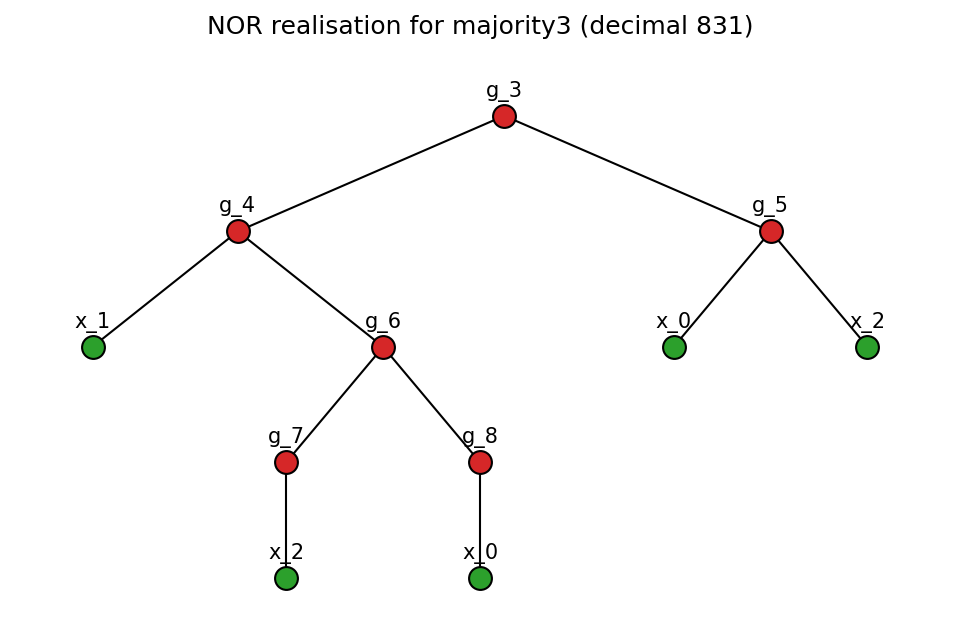

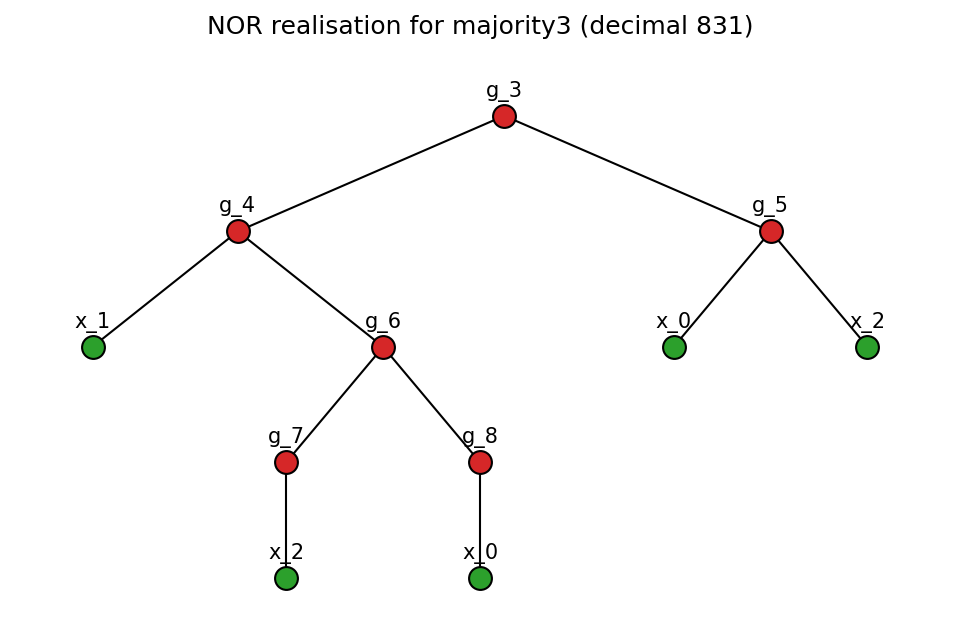

In [5]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
draw_tree(tree, ax=ax)
ax.set_title(f'NOR realisation for majority3 (decimal {truth.decimal})')
fig


The notebook leaves behind both the original behavioural Verilog file and the generated structural netlist under `python/examples/`, ready for inspection or further use.
